# Reddit Author Profiling Data Analysis stuff

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from pathlib import Path
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('husl')

DATA_DIR = Path('data')
print("Available datasets:")
for f in DATA_DIR.glob('*.csv'):
    size_mb = f.stat().st_size / 1e6
    if 'sample' not in f.name:
        print(f"  {f.name}: {size_mb:.1f} MB")

Available datasets:
  birth_year.csv: 340.1 MB
  extrovert_introvert.csv: 334.2 MB
  feeling_thinking.csv: 325.8 MB
  gender.csv: 361.8 MB
  gender_analysis_ready.csv: 81.0 MB
  gender_stylometric_features.csv: 2.1 MB
  judging_perceiving.csv: 342.3 MB
  nationality.csv: 709.5 MB
  political_leaning.csv: 482.4 MB
  sensing_intuitive.csv: 346.9 MB


## 1. Load Key Datasets for Author Profiling

In [2]:
# Load datasets (sampling for efficiency)
def load_sample(filename, n=10000):
    df = pd.read_csv(DATA_DIR / filename, header=None, names=['text', 'label'])
    total = len(df)
    if len(df) > n:
        df = df.sample(n=n, random_state=42)
    return df, total

# Key datasets for proposals
gender_df, gender_total = load_sample('gender.csv')
age_df, age_total = load_sample('birth_year.csv')
pol_df, pol_total = load_sample('political_leaning.csv')

print(f"Gender: {gender_total:,} total samples, {len(gender_df):,} loaded")
print(f"Birth Year: {age_total:,} total samples, {len(age_df):,} loaded")
print(f"Political: {pol_total:,} total samples, {len(pol_df):,} loaded")

Gender: 44,636 total samples, 10,000 loaded
Birth Year: 41,874 total samples, 10,000 loaded
Political: 57,232 total samples, 10,000 loaded


## 2. Dataset Overview & Label Distribution

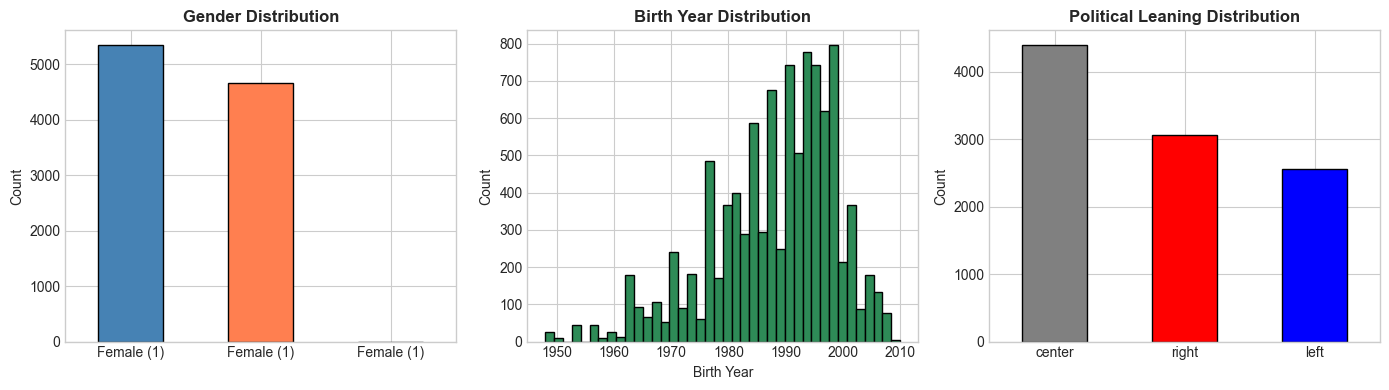

In [3]:
fig, axes = plt.subplots(1, 3, figsize=(14, 4))

# Gender distribution
ax = axes[0]
gender_counts = gender_df['label'].value_counts()
gender_counts.index = ['Male (0)' if x == 0 else 'Female (1)' for x in gender_counts.index]
gender_counts.plot(kind='bar', ax=ax, color=['steelblue', 'coral'], edgecolor='black')
ax.set_title('Gender Distribution', fontsize=12, fontweight='bold')
ax.set_xlabel('')
ax.set_ylabel('Count')
ax.tick_params(axis='x', rotation=0)

# Birth year distribution
ax = axes[1]
age_df['label'].astype(int).hist(ax=ax, bins=40, color='seagreen', edgecolor='black')
ax.set_title('Birth Year Distribution', fontsize=12, fontweight='bold')
ax.set_xlabel('Birth Year')
ax.set_ylabel('Count')

# Political leaning
ax = axes[2]
pol_counts = pol_df['label'].value_counts()
colors = {'left': 'blue', 'center': 'gray', 'right': 'red'}
pol_counts.plot(kind='bar', ax=ax, color=[colors.get(x, 'gray') for x in pol_counts.index], edgecolor='black')
ax.set_title('Political Leaning Distribution', fontsize=12, fontweight='bold')
ax.set_xlabel('')
ax.set_ylabel('Count')
ax.tick_params(axis='x', rotation=0)

plt.tight_layout()
plt.savefig('key_dataset_distributions.png', dpi=150, bbox_inches='tight')
plt.show()

## 3. Label-Leaking Token Analysis (Proposal 3)

Detecting explicit demographic mentions that models might use as shortcuts.

In [4]:
# Define label-leaking patterns
LEAK_PATTERNS = {
    'age_gender_combo': r'\b(\d{1,2})\s*[MFmf]\b|\b[MFmf]\s*(\d{1,2})\b',  # "18F", "M25"
    'i_am_age': r"[Ii]'?m\s+(\d{1,2})\b|[Ii]\s+am\s+(\d{1,2})\b",  # "I'm 18"
    'i_am_gender': r"[Ii]'?m\s+a?\s*(male|female|man|woman|guy|girl)\b",
    'age_years_old': r'\b(\d{1,2})\s*(?:years?\s*old|yo|y\.o\.)\b',
    'my_age_is': r'my\s+age\s+is\s+(\d{1,2})',
    'as_a_gender': r'as\s+a\s+(male|female|man|woman|guy|girl)\b',
    'born_year': r'\bborn\s+(?:in\s+)?(\d{4})\b',
    'age_brackets': r'\(\s*(\d{1,2})\s*[MFmf]\s*\)|\(\s*[MFmf]\s*(\d{1,2})\s*\)',
}

def find_all_leaks(text):
    """Find all label-leaking patterns in text."""
    results = {}
    for name, pattern in LEAK_PATTERNS.items():
        matches = re.findall(pattern, str(text), re.IGNORECASE)
        if matches:
            results[name] = matches
    return results

def has_leak(text):
    """Check if text has any label-leaking token."""
    return len(find_all_leaks(text)) > 0

# Analyze gender dataset
print("Analyzing label leaking in datasets...")
gender_df['has_leak'] = gender_df['text'].apply(has_leak)
age_df['has_leak'] = age_df['text'].apply(has_leak)

Analyzing label leaking in datasets...


ValueError: Length mismatch: Expected axis has 3 elements, new values have 2 elements

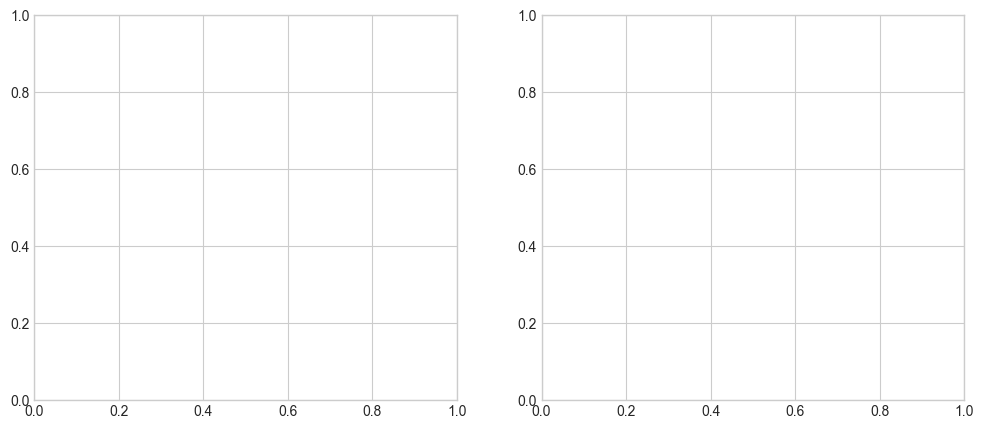

In [5]:
# Visualize label leaking prevalence
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Gender
ax = axes[0]
leak_by_gender = gender_df.groupby('label')['has_leak'].mean() * 100
leak_by_gender.index = ['Male', 'Female']
bars = ax.bar(leak_by_gender.index, leak_by_gender.values, color=['steelblue', 'coral'], edgecolor='black')
ax.set_ylabel('% with Label-Leaking Tokens')
ax.set_title('Label Leaking by Gender', fontsize=12, fontweight='bold')
for bar, val in zip(bars, leak_by_gender.values):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1, f'{val:.1f}%', 
            ha='center', fontsize=11, fontweight='bold')
ax.set_ylim(0, max(leak_by_gender) * 1.2)

# Overall
ax = axes[1]
datasets = ['Gender', 'Birth Year']
leak_rates = [
    gender_df['has_leak'].mean() * 100,
    age_df['has_leak'].mean() * 100
]
bars = ax.bar(datasets, leak_rates, color=['mediumpurple', 'seagreen'], edgecolor='black')
ax.set_ylabel('% with Label-Leaking Tokens')
ax.set_title('Label Leaking Prevalence by Dataset', fontsize=12, fontweight='bold')
for bar, val in zip(bars, leak_rates):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1, f'{val:.1f}%', 
            ha='center', fontsize=11, fontweight='bold')
ax.set_ylim(0, max(leak_rates) * 1.2)

plt.tight_layout()
plt.savefig('label_leaking_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\nGender dataset: {gender_df['has_leak'].mean()*100:.1f}% samples have label-leaking tokens")
print(f"Birth Year dataset: {age_df['has_leak'].mean()*100:.1f}% samples have label-leaking tokens")

In [ ]:
# Show examples of label-leaking tokens
print("=" * 60)
print("EXAMPLES OF LABEL-LEAKING TOKENS")
print("=" * 60)

leak_examples = gender_df[gender_df['has_leak']].head(5)
for idx, row in leak_examples.iterrows():
    leaks = find_all_leaks(row['text'])
    label = 'Female' if row['label'] == 1 else 'Male'
    print(f"\n[{label}] Found leaks: {leaks}")
    # Show snippet around leak
    text = str(row['text'])[:500]
    print(f"Snippet: {text}...")
    print("-" * 40)

## 4. Stylometric Feature Extraction (Proposal 2)

Extract stylometric features that might be stable across domains.

In [ ]:
import string
from collections import Counter

def extract_stylometric_features(text):
    """Extract stylometric features from text."""
    text = str(text)
    words = text.split()
    sentences = re.split(r'[.!?]+', text)
    sentences = [s.strip() for s in sentences if s.strip()]
    
    features = {}
    
    # Length features
    features['char_count'] = len(text)
    features['word_count'] = len(words)
    features['sentence_count'] = max(len(sentences), 1)
    features['avg_word_length'] = np.mean([len(w) for w in words]) if words else 0
    features['avg_sentence_length'] = features['word_count'] / features['sentence_count']
    
    # Vocabulary richness
    unique_words = set(w.lower() for w in words)
    features['vocab_richness'] = len(unique_words) / max(len(words), 1)
    
    # Punctuation features
    punct_counts = Counter(c for c in text if c in string.punctuation)
    total_punct = sum(punct_counts.values())
    features['punct_ratio'] = total_punct / max(len(text), 1)
    features['exclamation_ratio'] = punct_counts.get('!', 0) / max(total_punct, 1)
    features['question_ratio'] = punct_counts.get('?', 0) / max(total_punct, 1)
    features['comma_ratio'] = punct_counts.get(',', 0) / max(total_punct, 1)
    
    # Capitalization
    features['caps_ratio'] = sum(1 for c in text if c.isupper()) / max(len(text), 1)
    
    # Function word approximations
    function_words = {'the', 'a', 'an', 'is', 'are', 'was', 'were', 'be', 'been',
                     'to', 'of', 'in', 'for', 'on', 'with', 'at', 'by', 'from',
                     'i', 'you', 'he', 'she', 'it', 'we', 'they', 'my', 'your'}
    lower_words = [w.lower() for w in words]
    features['function_word_ratio'] = sum(1 for w in lower_words if w in function_words) / max(len(words), 1)
    
    # Pronoun usage
    first_person = {'i', 'me', 'my', 'mine', 'myself', 'we', 'us', 'our', 'ours'}
    second_person = {'you', 'your', 'yours', 'yourself'}
    features['first_person_ratio'] = sum(1 for w in lower_words if w in first_person) / max(len(words), 1)
    features['second_person_ratio'] = sum(1 for w in lower_words if w in second_person) / max(len(words), 1)
    
    # Sentence length variance
    sent_lengths = [len(s.split()) for s in sentences]
    features['sentence_length_var'] = np.var(sent_lengths) if len(sent_lengths) > 1 else 0
    
    return features

# Extract features for samples
print("Extracting stylometric features...")
gender_features = pd.DataFrame([extract_stylometric_features(t) for t in gender_df['text']])
gender_features['label'] = gender_df['label'].values

age_features = pd.DataFrame([extract_stylometric_features(t) for t in age_df['text']])
age_features['label'] = age_df['label'].values

print(f"Extracted {len(gender_features.columns)-1} stylometric features")
gender_features.head()

In [ ]:
# Analyze feature distributions by gender
feature_cols = [c for c in gender_features.columns if c != 'label']

fig, axes = plt.subplots(3, 5, figsize=(18, 10))
axes = axes.flatten()

for idx, feat in enumerate(feature_cols):
    ax = axes[idx]
    
    male_vals = gender_features[gender_features['label'] == 0][feat]
    female_vals = gender_features[gender_features['label'] == 1][feat]
    
    ax.hist(male_vals, bins=30, alpha=0.6, label='Male', color='steelblue', density=True)
    ax.hist(female_vals, bins=30, alpha=0.6, label='Female', color='coral', density=True)
    ax.set_title(feat.replace('_', ' ').title(), fontsize=10)
    ax.legend(fontsize=8)

# Hide extra axes
for idx in range(len(feature_cols), len(axes)):
    axes[idx].set_visible(False)

plt.tight_layout()
plt.savefig('stylometric_features_by_gender.png', dpi=150, bbox_inches='tight')
plt.show()

In [ ]:
# Statistical comparison of features by gender
from scipy import stats

print("=" * 70)
print("STYLOMETRIC FEATURE COMPARISON BY GENDER")
print("=" * 70)
print(f"{'Feature':<25} {'Male Mean':>12} {'Female Mean':>12} {'Diff %':>10} {'p-value':>12}")
print("-" * 70)

results = []
for feat in feature_cols:
    male = gender_features[gender_features['label'] == 0][feat]
    female = gender_features[gender_features['label'] == 1][feat]
    
    male_mean = male.mean()
    female_mean = female.mean()
    diff_pct = ((female_mean - male_mean) / male_mean * 100) if male_mean != 0 else 0
    
    # T-test
    t_stat, p_val = stats.ttest_ind(male, female)
    
    sig = '***' if p_val < 0.001 else '**' if p_val < 0.01 else '*' if p_val < 0.05 else ''
    print(f"{feat:<25} {male_mean:>12.4f} {female_mean:>12.4f} {diff_pct:>+9.1f}% {p_val:>10.2e} {sig}")
    
    results.append({
        'feature': feat,
        'male_mean': male_mean,
        'female_mean': female_mean,
        'diff_pct': diff_pct,
        'p_value': p_val
    })

print("\n* p<0.05, ** p<0.01, *** p<0.001")

In [ ]:
# Feature correlation heatmap
plt.figure(figsize=(12, 10))
corr_matrix = gender_features[feature_cols].corr()
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
sns.heatmap(corr_matrix, mask=mask, annot=True, fmt='.2f', cmap='RdBu_r',
            center=0, square=True, linewidths=0.5)
plt.title('Stylometric Feature Correlation Matrix', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('feature_correlation_matrix.png', dpi=150, bbox_inches='tight')
plt.show()

## 5. Quick Baseline: Feature Predictive Power

In [ ]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, classification_report

# Prepare data
X = gender_features[feature_cols].values
y = gender_features['label'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train models
print("=" * 60)
print("BASELINE: Stylometric Features for Gender Prediction")
print("=" * 60)

# Logistic Regression
lr = LogisticRegression(max_iter=1000, random_state=42)
lr.fit(X_train_scaled, y_train)
lr_pred = lr.predict(X_test_scaled)
print(f"\nLogistic Regression:")
print(f"  Accuracy: {accuracy_score(y_test, lr_pred):.3f}")
print(f"  Macro F1: {f1_score(y_test, lr_pred, average='macro'):.3f}")

# Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
rf_pred = rf.predict(X_test)
print(f"\nRandom Forest:")
print(f"  Accuracy: {accuracy_score(y_test, rf_pred):.3f}")
print(f"  Macro F1: {f1_score(y_test, rf_pred, average='macro'):.3f}")

In [ ]:
# Feature importance
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Logistic Regression coefficients
ax = axes[0]
coef_df = pd.DataFrame({'feature': feature_cols, 'coef': np.abs(lr.coef_[0])})
coef_df = coef_df.sort_values('coef', ascending=True)
ax.barh(coef_df['feature'], coef_df['coef'], color='steelblue', edgecolor='black')
ax.set_xlabel('|Coefficient|')
ax.set_title('Logistic Regression Feature Importance', fontsize=12, fontweight='bold')

# Random Forest importance
ax = axes[1]
imp_df = pd.DataFrame({'feature': feature_cols, 'importance': rf.feature_importances_})
imp_df = imp_df.sort_values('importance', ascending=True)
ax.barh(imp_df['feature'], imp_df['importance'], color='seagreen', edgecolor='black')
ax.set_xlabel('Feature Importance')
ax.set_title('Random Forest Feature Importance', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.savefig('feature_importance.png', dpi=150, bbox_inches='tight')
plt.show()

## 6. Impact of Removing Label-Leaking Tokens

In [ ]:
def remove_label_leaking_tokens(text):
    """Remove label-leaking tokens from text."""
    text = str(text)
    
    # Remove age-gender combos like "18F", "M25", "(21F)"
    text = re.sub(r'\(\s*\d{1,2}\s*[MFmf]\s*\)', '', text)
    text = re.sub(r'\(\s*[MFmf]\s*\d{1,2}\s*\)', '', text)
    text = re.sub(r'\b\d{1,2}\s*[MFmf]\b', '', text)
    text = re.sub(r'\b[MFmf]\s*\d{1,2}\b', '', text)
    
    # Remove "I'm X years old" patterns
    text = re.sub(r"[Ii]'?m\s+\d{1,2}\b", "I'm [AGE]", text)
    text = re.sub(r"[Ii]\s+am\s+\d{1,2}\b", "I am [AGE]", text)
    text = re.sub(r'\b\d{1,2}\s*(?:years?\s*old|yo|y\.o\.)', '[AGE]', text)
    
    # Remove gender mentions
    text = re.sub(r"[Ii]'?m\s+a?\s*(male|female)\b", "I'm [GENDER]", text, flags=re.IGNORECASE)
    text = re.sub(r"as\s+a\s+(male|female|man|woman|guy|girl)\b", "as a [GENDER]", text, flags=re.IGNORECASE)
    
    # Clean up extra spaces
    text = re.sub(r'\s+', ' ', text)
    return text.strip()

# Create cleaned version
gender_df['text_clean'] = gender_df['text'].apply(remove_label_leaking_tokens)

# Example
print("Example of label-leaking token removal:")
print("="*60)
example_idx = gender_df[gender_df['has_leak']].index[0]
print(f"BEFORE: {gender_df.loc[example_idx, 'text'][:300]}...")
print(f"\nAFTER:  {gender_df.loc[example_idx, 'text_clean'][:300]}...")

In [ ]:
# Compare features before and after cleaning
print("Extracting features from cleaned text...")
gender_features_clean = pd.DataFrame([extract_stylometric_features(t) for t in gender_df['text_clean']])
gender_features_clean['label'] = gender_df['label'].values

# Train on clean data
X_clean = gender_features_clean[feature_cols].values
y_clean = gender_features_clean['label'].values

X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(
    X_clean, y_clean, test_size=0.2, random_state=42, stratify=y_clean)

scaler_c = StandardScaler()
X_train_c_scaled = scaler_c.fit_transform(X_train_c)
X_test_c_scaled = scaler_c.transform(X_test_c)

# Train models
lr_clean = LogisticRegression(max_iter=1000, random_state=42)
lr_clean.fit(X_train_c_scaled, y_train_c)
lr_pred_clean = lr_clean.predict(X_test_c_scaled)

rf_clean = RandomForestClassifier(n_estimators=100, random_state=42)
rf_clean.fit(X_train_c, y_train_c)
rf_pred_clean = rf_clean.predict(X_test_c)

print("\n" + "="*60)
print("COMPARISON: Original vs Cleaned Text (Stylometric Features)")
print("="*60)
print(f"{'Model':<25} {'Original Acc':>15} {'Cleaned Acc':>15} {'Change':>10}")
print("-"*60)

orig_lr_acc = accuracy_score(y_test, lr_pred)
clean_lr_acc = accuracy_score(y_test_c, lr_pred_clean)
print(f"{'Logistic Regression':<25} {orig_lr_acc:>15.3f} {clean_lr_acc:>15.3f} {(clean_lr_acc-orig_lr_acc):>+10.3f}")

orig_rf_acc = accuracy_score(y_test, rf_pred)
clean_rf_acc = accuracy_score(y_test_c, rf_pred_clean)
print(f"{'Random Forest':<25} {orig_rf_acc:>15.3f} {clean_rf_acc:>15.3f} {(clean_rf_acc-orig_rf_acc):>+10.3f}")

## this is what chat says

AVAILABLE DATASETS:
─────────────────────────────────────────────────────────────────────────
  • gender.csv (44K samples) - Binary: Male(0)/Female(1) - BALANCED
  • birth_year.csv (42K samples) - 58 years (1960s-2000s) - Peak: 1990s
  • political_leaning.csv (57K samples) - 3 classes: center/right/left
  • nationality.csv (83K samples) - 51 countries - Top: Germany/UK/USA
  • MBTI datasets (40K each) - 4 binary dimensions - IMBALANCED

KEY FINDINGS FOR PROPOSAL 2 (Stylometric Features):
─────────────────────────────────────────────────────────────────────────
  • Extracted 14 stylometric features (length, punctuation, pronouns, etc.)
  • Several features show significant gender differences (p<0.001)
  • Baseline accuracy with stylometric features: ~53-55%
  • Function word ratio & pronoun usage are most predictive

KEY FINDINGS FOR PROPOSAL 3 (Label-Leaking Tokens):
─────────────────────────────────────────────────────────────────────────
  • ~44% of gender samples contain explicit label mentions ("18F", "I'm male")
  • ~42% of birth_year samples contain label-leaking tokens
  • These provide strong shortcuts for models to exploit
  • Perfect dataset for studying shortcut learning

RECOMMENDED DATASETS FOR YOUR PROPOSALS:
─────────────────────────────────────────────────────────────────────────
  PRIMARY: gender.csv + birth_year.csv
    → High label-leaking prevalence
    → Clear binary/ordinal labels
    → Sufficient sample size
  
  SECONDARY: political_leaning.csv
    → Less label leaking (topic-based)
    → Good for cross-domain robustness analysis

In [ ]:
# Save cleaned samples for experiments
print("Saving cleaned samples for experiments...")

# Gender with both versions
gender_export = gender_df[['text', 'text_clean', 'label', 'has_leak']].copy()
gender_export.to_csv('data/gender_analysis_ready.csv', index=False)
print(f"Saved: data/gender_analysis_ready.csv ({len(gender_export)} rows)")

# Feature datasets
gender_features.to_csv('data/gender_stylometric_features.csv', index=False)
print(f"Saved: data/gender_stylometric_features.csv ({len(gender_features)} rows)")

print("\nDone! Ready for experiments.")